In [1]:
import numpy as np
import tensorflow as tf
import itertools as it

2022-05-31 20:38:38.971167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/libreoffice/program:/usr/local/lib:/usr/lib/libreoffice/program:/usr/local/lib:/usr/local/lib::/opt/gurobi950/linux64/lib:/lib/x86_64-linux-gnu:/home/matt/.mujoco/mjpro150/bin:/opt/gurobi950/linux64/lib:/lib/x86_64-linux-gnu:/home/matt/.mujoco/mjpro150/bin:/opt/gurobi950/linux64/lib:/lib/x86_64-linux-gnu:/home/matt/.mujoco/mjpro150/bin
2022-05-31 20:38:38.971188: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
n_links = 5
n_nodes = 4

adjacencies = [
	[0, 1],
	[0, 2],
	[1, 2],
	[1, 3],
	[2, 3]
]

triplist = [[0, 3]]
d_rs = [6.0]

paths = [ 
	[0, 3],
	[0, 2, 4],
	[1, 4]
]

linkpath = np.zeros((n_links, 3))
for i, links in enumerate(paths):
	for lid in links:
		linkpath[lid, i] = 1.0	

In [3]:
m_true = np.array([10., 1., 1., 1., 10.])
m_init = np.array([9.0, 2.0, 2.0, 2.0, 9.0])
b_true = np.array([0., 50., 10., 50., 0.])
b_init = b_true
x = tf.constant(np.array([4., 2., 2., 2., 4.]), dtype=tf.float64)
X = tf.expand_dims(x, 0)
rng = tf.random.Generator.from_seed(1234)
n_samples = 100
data = x + rng.normal((n_samples, n_links), mean=0, stddev=0.01, dtype=tf.float64)
#true_cost = np.array([40, 52, 12, 52, 40], dtype=np.float64)
true_cost = m_true * x + b_true
q_true = np.array([6.0])
q_init = np.array([5.0])

optimizer = tf.keras.optimizers.Adam()

2022-05-31 20:38:41.437582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/libreoffice/program:/usr/local/lib:/usr/lib/libreoffice/program:/usr/local/lib:/usr/local/lib::/opt/gurobi950/linux64/lib:/lib/x86_64-linux-gnu:/home/matt/.mujoco/mjpro150/bin:/opt/gurobi950/linux64/lib:/lib/x86_64-linux-gnu:/home/matt/.mujoco/mjpro150/bin:/opt/gurobi950/linux64/lib:/lib/x86_64-linux-gnu:/home/matt/.mujoco/mjpro150/bin
2022-05-31 20:38:41.437621: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 20:38:41.437652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mb-gazelle): /proc/driver/nvidia/version does not exist
2022-05-31 20:38:41.438446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This Ten

In [4]:
class StochasticNetworkLoading(tf.keras.Model):
    def __init__(self, n_nodes, triplist, linklist, m_init, b_init, q_init, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._m = tf.Variable(np.log(m_init), name="m", dtype=self.dtype, trainable=self.trainable)
        self.b = tf.Variable(b_init, name="b", dtype=self.dtype, trainable=False)
        self._q = tf.Variable(np.sqrt(q_init), name="q", dtype=self.dtype, trainable=self.trainable)
        self.linklist = linklist
        self.n_nodes = n_nodes
        self.triplist = triplist
        self.I = np.identity(self.n_nodes)

    @property
    def m(self):
        return tf.exp(self._m)

    @property
    def q(self):
        return self._q ** 2

    def link_cost(self, x):
        return tf.multiply(self.m, x) + self.b

    def link_logits(self, x):
        return tf.exp(-self.link_cost(x))

    def transition_logits(self, x):
        n_samples = x.shape[0]
        indices = [
            list(it.chain([i], adj))
            for i, adj in it.product(range(n_samples), self.linklist)
        ]
        return tf.SparseTensor(
            indices=indices,
            values=tf.reshape(self.link_logits(x), [-1]),
            dense_shape=(n_samples, self.n_nodes, self.n_nodes)
        )

    @property
    def Q(self):
        return tf.SparseTensor(
            indices=self.triplist, 
            values=self.q, 
            dense_shape=(n_nodes, n_nodes)
        )

    def link_weights(self, L):
        _L = tf.sparse.to_dense(L)
        Q = tf.sparse.to_dense(self.Q)
        V = tf.linalg.inv(self.I - _L)
        _V = 1.0 / tf.where(tf.equal(V, 0.0), 1.0, V)
        return tf.einsum("iru, ivs, irs, rs -> iuv", V, V, _V, Q)

    def normalizer(self, L):
        # TODO support multiple OD: tf.einsum("iuv, iru, ivs, irs, rs -> iuv", L, V, V, 1.0/V, Q)
        V = tf.linalg.inv(self.I - tf.sparse.to_dense(L))
        V_rs = 1.0 / V[:, self.r, self.s]
        V_r = V[:, self.r, :]
        V_s = V[:, :, self.s]
        return tf.einsum("iu, iv, i -> iuv", V_r, V_s, V_rs)

    def link_assignment(self, x):
        L = self.transition_logits(x)
        W = self.link_weights(L)
        H = L * W
        n_samples = x.shape[0]
        return tf.reshape(H.values, [n_samples, -1])

    def call(self, x):
        x = tf.cast(x, self.dtype)
        return self.link_assignment(x)

In [5]:
model = StochasticNetworkLoading(n_nodes, triplist, adjacencies, m_init, b_init, q_init, dtype=tf.float64)
print(model.trainable_variables)
print(f"q = {model.q}, m  = {model.m}")

[<tf.Variable 'm:0' shape=(5,) dtype=float64, numpy=array([2.19722458, 0.69314718, 0.69314718, 0.69314718, 2.19722458])>, <tf.Variable 'q:0' shape=(1,) dtype=float64, numpy=array([2.23606798])>]
q = [5.], m  = [9. 2. 2. 2. 9.]


In [6]:
true_model = StochasticNetworkLoading(n_nodes, triplist, adjacencies, m_true, b_true, q_true, dtype=tf.float64, trainable=False)

In [7]:
print(f"{X} =?= {true_model(X)}")
print(f"Q = {tf.sparse.to_dense(true_model.Q)}")
print(f"link cost = {true_model.link_cost(X)}")
print(f"link logits = {true_model.link_logits(X)}")
print(f"L = {tf.sparse.to_dense(true_model.transition_logits(X))}")
print(f"W = {true_model.link_weights(true_model.transition_logits(X))}")

[[4. 2. 2. 2. 4.]] =?= [[4. 2. 2. 2. 4.]]
Q = [[0. 0. 0. 6.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
link cost = [[40. 52. 12. 52. 40.]]
link logits = [[4.24835426e-18 2.61027907e-23 6.14421235e-06 2.61027907e-23
  4.24835426e-18]]
L = [[[0.00000000e+00 4.24835426e-18 2.61027907e-23 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 6.14421235e-06 2.61027907e-23]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.24835426e-18]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]]
W = [[[6.00000000e+00 9.41541067e+17 7.66201600e+22 1.80352568e+40]
  [2.54901255e-17 4.00000000e+00 3.25509583e+05 7.66201600e+22]
  [3.13233488e-22 4.91536988e-05 4.00000000e+00 9.41541067e+17]
  [1.99609023e-39 3.13233488e-22 2.54901255e-17 6.00000000e+00]]]


In [8]:
loss = tf.reduce_mean((data - model(data))**2)
i = 0
while loss > 1e-8 and i <= 10000:
	with tf.GradientTape() as tape:
		x_hat = model(data)
		loss = (
			tf.reduce_mean((data - x_hat)**2)
		)
	grads = tape.gradient(loss, model.trainable_variables)
	optimizer.apply_gradients(zip(grads, model.trainable_variables))
	if i % 1000 == 0:
		print(f"{i}: loss={loss.numpy():0.4g}, demand={model.q}, cost coefficients={model.m}, link flow={x_hat.numpy().mean(0)}, link cost={model.link_cost(data).numpy().mean(0)}")
	i += 1
print(f"{i} [FINAL]: loss={loss.numpy():0.4g}, demand={model.q},cost coefficients={model.m}, link flow={x_hat.numpy().mean(0)}, link cost={model.link_cost(data).numpy().mean(0)}")

0: loss=3.39, demand=[4.99552887], cost coefficients=[9.0090045  1.99800101 2.002001   1.99800101 9.0090045 ], link flow=[4.91168559 0.08831441 4.82324302 0.08844257 4.91155743], link cost=[36.03407105 53.99690421 14.0036827  53.99685672 36.03412713]
1000: loss=0.0159, demand=[5.9720789], cost coefficients=[9.82010924 1.83065247 2.18663451 1.8298825  9.8192754 ], link flow=[3.98744023 1.98454084 2.00506498 1.98237525 3.98960582], link cost=[39.27831472 53.66213157 14.37292029 53.66054779 39.27504065]
2000: loss=0.01583, demand=[5.9839373], cost coefficients=[9.80969055 1.81828137 2.19662051 1.81521067 9.80770763], link flow=[3.99338036 1.99055689 2.0049874  1.98839296 3.99554428], link cost=[39.23664221 53.63738378 14.39289068 53.63119784 39.22877203]
3000: loss=0.01576, demand=[5.98401327], cost coefficients=[9.79002248 1.79677956 2.21446965 1.78973814 9.78605491], link flow=[3.99340843 1.99060474 2.0049623  1.98844613 3.99556704], link cost=[39.1579742  53.59437044 14.42858613 53.580

In [9]:
print(f"learned flow = {model(tf.expand_dims(x, 0)).numpy()}; true flow = {true_model(tf.expand_dims(x, 0)).numpy()}")
print(f"Learned cost = {model.link_cost(x).numpy()}; true cost = {true_model.link_cost(x).numpy()}")
print(f"learned path cost = {linkpath.T @  model.link_cost(x).numpy()}; true path cost = {linkpath.T @ true_model.link_cost(x).numpy()}")
print(f"m = {model.m}, (true m = {m_true})")
print(f"b = {model.b}")
print(f"OD demand = {model.q}")

learned flow = [[3.99467367 1.99278903 2.00010457 1.9945691  3.9928936 ]]; true flow = [[4. 2. 2. 2. 4.]]
Learned cost = [34.56645273 52.39675289 17.82663587 52.18771731 34.35831   ]; true cost = [40. 52. 12. 52. 40.]
learned path cost = [86.75417004 86.75139861 86.75506289]; true path cost = [92. 92. 92.]
m = [8.64161318 1.19837644 3.91331794 1.09385865 8.5895775 ], (true m = [10.  1.  1.  1. 10.])
b = <tf.Variable 'b:0' shape=(5,) dtype=float64, numpy=array([ 0., 50., 10., 50.,  0.])>
OD demand = [5.98746269]


In [10]:
optimizer.learning_rate

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [11]:
import time

In [13]:
# Solving for SUE with fixed parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
x_init = tf.Variable(np.zeros((1, n_links)), name="x_init", dtype=true_model.dtype)
x_ue = tf.Variable(true_model(x_init).numpy(), name="x_ue", dtype=true_model.dtype)
print(x_ue.numpy())
loss = 1
l = []
i = 0
t0 = time.time()
while loss > 1e-4:
    with tf.GradientTape() as tape:
        x_hat = true_model(x_ue)
        loss = (
            tf.reduce_mean((x_ue - x_hat)**2)
        )
    trainable_vars = [x_ue]
    grads = tape.gradient(loss, trainable_vars)
    #print(f"{i}: {x_ue} -> {x_hat} {grads}")
    optimizer.apply_gradients(zip(grads, trainable_vars))
    l.append(loss.numpy())
    if i % 100 == 0:
        print(f"{i}: loss={loss.numpy():0.4g}; x={x_ue.numpy()}")
    i += 1
duration = time.time()-t0

print()
print(f"{i} iterations in {duration:0.2f} seconds")
print(f"{i}: loss={loss.numpy():0.4g}; x={x_ue.numpy()}")


[[6.00000000e+00 2.54901255e-17 6.00000000e+00 2.54901255e-17
  6.00000000e+00]]
0: loss=14.4; x=[[5.90000026 0.09999974 5.90000013 0.09999974 5.90000026]]
100: loss=0.008309; x=[[3.95642905 1.89309236 2.24389776 1.89309236 3.95642905]]

187 iterations in 1.43 seconds
187: loss=9.93e-05; x=[[3.99516699 1.99069109 2.02750846 1.99069109 3.99516699]]


In [14]:
import matplotlib.pyplot as plt

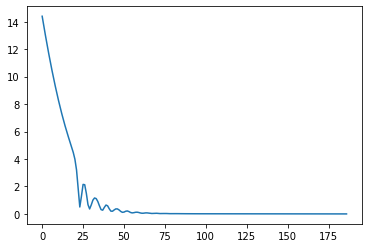

In [15]:
plt.plot(l)

In [16]:
# Solving for parameters from observations at SUE
opt1 = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt2 = tf.keras.optimizers.Adam(learning_rate=1e-2)
x_init = tf.Variable(np.zeros((1, n_links)), name="x_init", dtype=true_model.dtype)
x_ue = tf.Variable(true_model(x_init).numpy(), name="x_ue", dtype=true_model.dtype)
model = StochasticNetworkLoading(n_nodes, triplist, adjacencies, m_init, b_init, q_init, dtype=tf.float64)
print(x_ue.numpy())
loss = 1
ue_loss = 1
reconstruction_loss = 1
ue_losses = []
recon_errors = []
i = 0
t0 = time.time()
x_minimizer = tf.reduce_mean(data, 0)
print(f"best reconstruction error: {tf.reduce_mean((data - x_minimizer)**2)}")
best_error = tf.reduce_mean((data - x_minimizer)**2)
while ue_loss > 1e-8 or reconstruction_loss > 1e-2:
    with tf.GradientTape() as t1, tf.GradientTape() as t2:
        x_hat = model(x_ue)
        ue_loss = tf.reduce_mean((x_ue - x_hat)**2)
        reconstruction_loss = tf.reduce_mean((x_hat - data)**2) / best_error - 1
        ue_losses.append(ue_loss.numpy())
        recon_errors.append(reconstruction_loss.numpy())
        loss = ue_loss + reconstruction_loss
    grads = t1.gradient(reconstruction_loss, model.trainable_variables)
    #print(f"{i}: {x_ue} -> {x_hat} {grads}")
    opt1.apply_gradients(zip(grads, model.trainable_variables))
    grads = t2.gradient(ue_loss, [x_ue])
    opt2.apply_gradients(zip(grads, [x_ue]))
    if i % 1000 == 0:
        print(f"{i}: ue loss={ue_loss.numpy():0.4g}; reconstruction loss={reconstruction_loss.numpy():0.4g} x={x_ue.numpy()}; q={model.q}")
    i += 1
duration = time.time()-t0

print()
print(f"{i} iterations in {duration:0.2f} seconds")
print(f"{i}: ue loss={ue_loss.numpy():0.4g}; reconstruction loss={reconstruction_loss.numpy():0.4g} x={x_ue.numpy()}; q={model.q}")

[[6.00000000e+00 2.54901255e-17 6.00000000e+00 2.54901255e-17
  6.00000000e+00]]
best reconstruction error: 9.20099846291531e-05
0: ue loss=14.6; reconstruction loss=1.956e+04 x=[[5.99000002 0.00999997 5.99000001 0.00999997 5.99000002]]; q=[5.00044722]
1000: ue loss=0.01131; reconstruction loss=2955 x=[[3.702074   1.28059414 2.68796522 1.28143546 3.70141649]]; q=[5.1257992]
2000: ue loss=0.0006922; reconstruction loss=386.8 x=[[3.7756965  1.76099274 2.06644696 1.76133724 3.77555292]]; q=[5.58253168]
3000: ue loss=6.748e-06; reconstruction loss=32.36 x=[[3.92308117 1.98380447 1.93940851 1.9837761  3.92315201]]; q=[5.91267952]
4000: ue loss=1.867e-07; reconstruction loss=0.3028 x=[[3.99723382 2.00532465 1.9906932  2.00530207 3.99725701]]; q=[6.00217288]

4478 iterations in 66.55 seconds
4478: ue loss=9.938e-09; reconstruction loss=0.0084 x=[[4.00063209 2.00151173 1.99891724 2.00149564 4.00064763]]; q=[6.00198502]


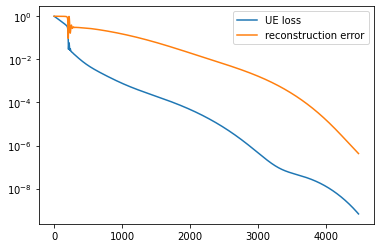

In [18]:
fig, ax = plt.subplots()
#ax2 = ax.twinx()
ax.plot(ue_losses / ue_losses[0], label="UE loss")
ax.plot(recon_errors / recon_errors[0], label="reconstruction error")
#ax2.set_yscale("log")
#plt.plot(recon_errors / recon_errors[0], label="reconstruction loss")
ax.set_yscale("log")
ax.legend()

In [19]:
print(f"learned flow = {model(tf.expand_dims(x, 0)).numpy()}; true flow = {true_model(tf.expand_dims(x, 0)).numpy()}")
print(f"Learned cost = {model.link_cost(x).numpy()}; true cost = {true_model.link_cost(x).numpy()}")
print(f"learned path cost = {linkpath.T @  model.link_cost(x).numpy()}; true path cost = {linkpath.T @ true_model.link_cost(x).numpy()}")
print(f"m = {model.m}, (true m = {m_true})")
print(f"b = {model.b}")
print(f"OD demand = {model.q}")

learned flow = [[4.00113435 2.00085066 2.00066591 2.00046844 4.00151658]]; true flow = [[4. 2. 2. 2. 4.]]
Learned cost = [39.52798885 53.74653022 14.21863371 53.74739344 39.52866102]; true cost = [40. 52. 12. 52. 40.]
learned path cost = [93.27538228 93.27528357 93.27519123]; true path cost = [92. 92. 92.]
m = [9.88199721 1.87326511 2.10931685 1.87369672 9.88216525], (true m = [10.  1.  1.  1. 10.])
b = <tf.Variable 'b:0' shape=(5,) dtype=float64, numpy=array([ 0., 50., 10., 50.,  0.])>
OD demand = [6.00198502]
